Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/07.introduction_to_pytorch_lightning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchinfo import summary

torch.random.manual_seed(17);

# Introduction to PyTorch Lightning

This handout introduces **PyTorch Lightning**, a lightweight PyTorch wrapper (with a high-level interface) that simplifies the training process of neural networks and is designed to abstract away boilerplate code. PyTorch Lightning to PyTorch is like Keras to Tensorfolw, but with more flexibility and support for both researchers and engineers.

PyTorch Lightning introduces three main abstractions to simplify and organize the training process:

* **LightningModule:** The `LightningModule` is the core abstraction in PyTorch Lightning, encapsulating the essential components of a PyTorch model. It organizes the training logic, loss computation, and optimization into a modular structure. By subclassing `LightningModule`, you define the architecture and training steps of your neural network in a standardized way. This abstraction encourages cleaner and more modular code.

* **LightningDataModule:** The `LightningDataModule` abstracts away the data-related components of the model. It encapsulates the data preparation, loading, and processing steps.

* **Trainer:** The `Trainer` abstraction in PyTorch Lightning is responsible for orchestrating the training process. It implements the training loop, managing optimization, configuring distributed training, and implementing early stopping.

These abstractions help modularize the code, making it more readable, reusable, and scalable. They also contribute to PyTorch Lightning's goal of simplifying the training process by abstracting away the boilerplate code, allowing practitioners to focus more on experiment design and less on implementation details.

## Loading the data
We'll start by loading the `FashionMNIST` dataset used in Example 2 of the last handout.

In [2]:
data_path = './datasets'

ds_rest = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
ds_train, ds_val = random_split(ds_rest, [.8, .2])
ds_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

len(ds_train), len(ds_val), len(ds_test)

(48000, 12000, 10000)

Here are the corresponding data loaders:

In [3]:
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=2, persistent_workers=True)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=2, persistent_workers=True)
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=2, persistent_workers=True)

## Building the model

Next we build a model similar to that of Example 2 of the last handout. We'll do that by subclassing the`lightning.LightningModule` class instead of the `torch.nn.Module` class. This `lightning.LightningModule` is a child class of `torch.nn.Module`, adding multiple life-cycle functions that take care of much of the training process boilerplate code.

It organizes your PyTorch code into six main sections:
* Initialization (`__init__`) and `forward()` just like `nn.Module`.
* The training step (`training_step()`): This is what happens to a given batch during training up to but not including the optimizer's steps. Those will be taken care of by the Trainer. This is the place where the loss function can be defined and used.
* The validation step (`validation_step()`): This is what happens to a given validation batch; it calculates and returns validation loss and metrics.
* The test set (`test_step()`): This is what happens to a given testing batch; it calculates and returns testing loss and metrics.
* Configuration of optimizers and learning rate schedulers (`configure_optimizers()`): This is where the optimizer is created, configured, and returned.

At a minimum, the `training_step()` and  `configure_optimizers()` methods must be implemented.

First we make the necessary imports:

In [4]:
import lightning as L
from torchmetrics.functional import accuracy

And here is the model:

In [5]:
class FashionModel(L.LightningModule):
    def __init__(self, lr=0.001, weight_decay=0.01):
        super().__init__()
        
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log("loss", loss, prog_bar=True)
        self.log("accuracy", accuracy(y_hat, y, task="multiclass", num_classes=10), prog_bar=True)
        
        return loss
 
    def configure_optimizers(self):
        return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

model = FashionModel()

As you can see, the model has the same layers as those of Example 2 of the previous handout. And just like that, we can summarize it:

In [6]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
FashionModel                             --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       200,960
│    └─BatchNorm1d: 2-3                  512
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       32,896
│    └─BatchNorm1d: 2-6                  256
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0

and plot it:

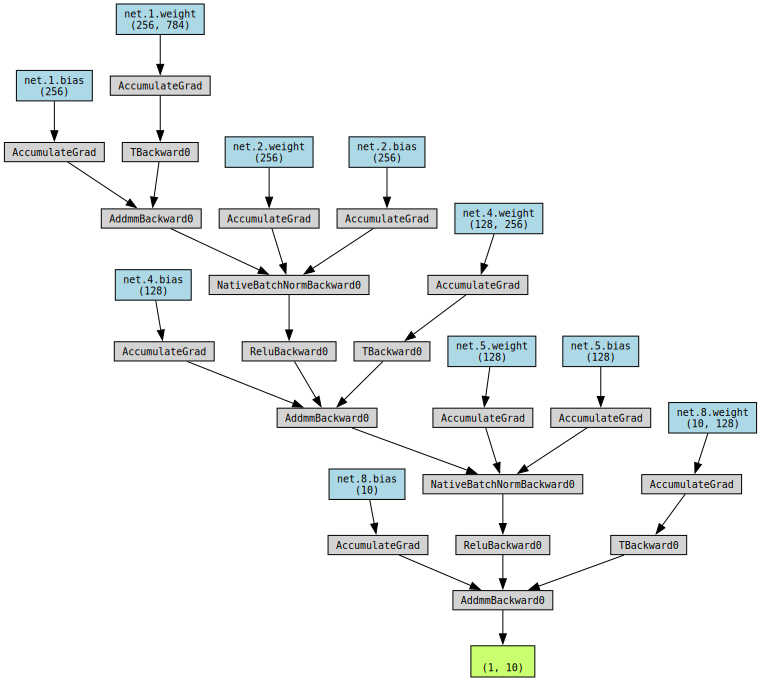

In [7]:
from torchviz import make_dot
model.eval()
make_dot(model(ds_train[0][0].unsqueeze(dim=0)), params=dict(model.named_parameters()))

We can now train it. But instead of creating our own training loop, we use lightening's `Trainer`. As you see below we only need to specify the maximum number of epochs, we want to train the model for. Keep in mind that trainer can do a lot, depending on the large number of parameters passed to it, many of which we will see in subsequent examples and handouts.

After that we call the trainer's `fit` method, which implements the training loop, passing it the model to train along with the training data loader.

In [8]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=model, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 235 K 
------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


Training: |                                                                                          | 0/? [00…

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's evaluate it:

In [9]:
model.eval()
acc = 0
for x_batch, y_batch in dl_test:
    preds = model(x_batch)
    acc += accuracy(torch.argmax(preds, dim=1), y_batch, task="multiclass", num_classes=10)

acc /= len(dl_test)
print("Accuracy:", acc.item())

Accuracy: 0.8418591022491455


## Using a data module

The third main abstraction of lightning is the data module. The above example uses the ordinary torch datasets and data loaders in training the model. PyTorch lightning provides a `lightening.LightningDataModule` class that can be subclassed to streamline the dataset preparation and loading. This is , as you can see below, a simple module where:

* the dataset is downloaded and prepared inside the `prepare_data(self)` method.
* the dataset is setup (split into various sets and transformed as needed) inside the `setup(self, stage=None)`.
* the relevant data loaders are created and returned under the methods `train_dataloader(self)`, `val_dataloader(self)`, and `test_dataloader(self)`.

Here is a data module for the above FashionMNIST data.

In [10]:
class FashionDataModule(L.LightningDataModule):
    def __init__(self, data_path='./datasets'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        datasets.FashionMNIST(root=self.data_path, download=True) 

    def setup(self, stage=None): # stage is either 'fit', 'validate', 'test', or 'predict'
        self.ds_train, self.ds_val = random_split(
            datasets.FashionMNIST(data_path, train=True, download=True, 
                                  transform=transforms.ToTensor()), [.8, .2])
        self.ds_test = datasets.FashionMNIST(data_path, train=False, download=True, 
                                             transform=transforms.ToTensor())

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=64, num_workers=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=64, num_workers=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=64, num_workers=2, persistent_workers=True)
    
fashion_dm = FashionDataModule()

Using this data module, we can train the above model for 5 extra epochs using only 100 training batches per epoch, again to show you the different arguments of the trainer.

In [11]:
trainer = L.Trainer(limit_train_batches=100, max_epochs=5)
trainer.fit(model=model, datamodule=fashion_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 235 K 
------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


Training: |                                                                                          | 0/? [00…

`Trainer.fit` stopped: `max_epochs=5` reached.


Let's evaluate it:

In [12]:
model.eval()
acc = 0
for x_batch, y_batch in fashion_dm.test_dataloader():
    preds = model(x_batch)
    acc += accuracy(torch.argmax(preds, dim=1), y_batch, task="multiclass", num_classes=10)

acc /= len(dl_test)
print("Accuracy:", acc.item())

Accuracy: 0.8445461988449097


## Visualizing the results with Tensorboard

**TensorBoard** is a visualization tool provided by TensorFlow for monitoring and debugging machine learning models. While TensorFlow-centric, it can also be used with PyTorch models and other frameworks. TensorBoard offers a user-friendly interface to visualize and analyze various aspects of the training process and model performance. Lightning uses a TensorBoard logger (by default if tensorboard is found), to log relevant information about the progress of training. This allows us to seamlessly integrate TensorBoard into our PyTorch workflows and leverage its visualization capabilities for improved model understanding and debugging.

Here is how we can display the logs of the above model using TensorBoard.

In [13]:
# Install TensorBoard
! pip install tensorboard --quiet

# Start TensorBoard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Adding validation and test steps
The last model we trained implemented only the `training_step()` and  `configure_optimizers()` methods. Let's add a validation and test step. 

In [14]:
class FashionModel(L.LightningModule):
    def __init__(self, lr=0.001, weight_decay=0.01):
        super().__init__()

        self.lr = lr
        self.weight_decay = weight_decay
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log("loss", loss, prog_bar=True)
        self.log("accuracy", accuracy(y_hat, y, task="multiclass", num_classes=10), prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy(y_hat, y, task="multiclass", num_classes=10), prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", accuracy(y_hat, y, task="multiclass", num_classes=10), prog_bar=True)
        
        return loss
        
    def configure_optimizers(self):
        return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

model = FashionModel()

Let's train this new model. But this time, we will use a new logger: `lightning.pytorch.loggers.CSVLogger`. This logger will record the metrics into a CSV file, which we can read and utilize to plot the training and validation learning curves. Let's save the log files in a folder named `./logs` under a given name for the model (`fashionMNIST_v1_0`). Once we create the logger, we pass it to the trainer.

In [15]:
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="fashionMNIST_v1_0")

trainer = L.Trainer(max_epochs=10, logger=logger)
trainer.fit(model=model, datamodule=fashion_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 235 K 
------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


Sanity Checking: |                                                                                   | 0/? [00…

Training: |                                                                                          | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

`Trainer.fit` stopped: `max_epochs=10` reached.


Because we implemented a testing step, we can evaluate the model like this:

In [16]:
trainer.test(model, datamodule=fashion_dm)

Testing: |                                                                                           | 0/? [00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.843500018119812     │
│         test_loss         │    0.4638446271419525     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4638446271419525, 'test_accuracy': 0.843500018119812}]

To use the CSVLogger's log file (`metrics.csv`), we first read it into a dataframe. Adjust the version number part of the file name as needed.

In [17]:
hist = pd.read_csv('./logs/fashionMNIST_v1_0/version_1/metrics.csv')
hist

,accuracy,step,loss,epoch,val_loss,val_accuracy,test_loss,test_accuracy
0,0.296875,49,2.046117,0,NaN,NaN,NaN,NaN
1,0.328125,99,1.857239,0,NaN,NaN,NaN,NaN
2,0.562500,149,1.557151,0,NaN,NaN,NaN,NaN
3,0.640625,199,1.464682,0,NaN,NaN,NaN,NaN
4,0.593750,249,1.498453,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
156,0.734375,7399,0.558630,9,NaN,NaN,NaN,NaN
157,0.875000,7449,0.528945,9,NaN,NaN,NaN,NaN
158,0.843750,7499,0.452537,9,NaN,NaN,NaN,NaN
159,NaN,7499,NaN,9,0.454147,0.85025,NaN,NaN


For training, use the `accuracy` and `loss` columns, dropping any `NaN` values. Similarly, use `val_accuracy` and `val_loss` for validation, and `test_accuracy` and `test_loss` for testing. Let's plot the training curves:

array([[<Axes: >, <Axes: >]], dtype=object)

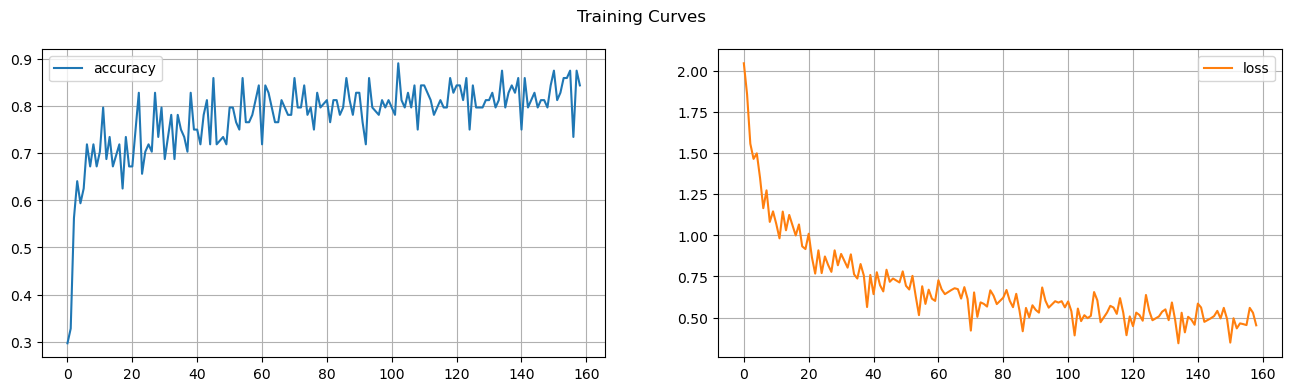

In [18]:
hist[['accuracy', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Training Curves")

Similarly, here are the validation curves:

array([[<Axes: >, <Axes: >]], dtype=object)

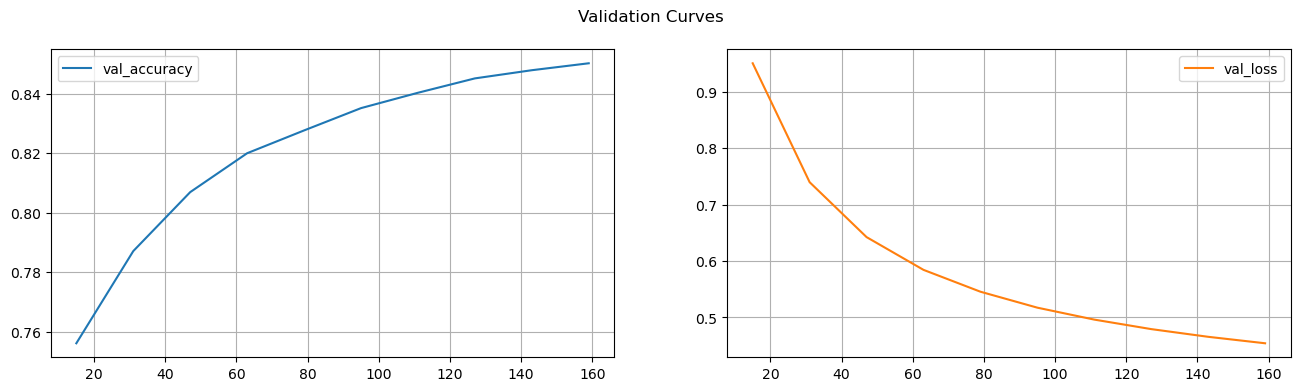

In [19]:
hist[['val_accuracy', 'val_loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                                 grid=True, title="Validation Curves")

There is no need to plot the testing curves since there is only one row, which is not enough to plot a curve.

In [20]:
hist[['test_accuracy', 'test_loss']].dropna()

,test_accuracy,test_loss
160,0.8435,0.463845


## Using hooks

The `LightningModule`-based model can also define methods that perform custom actions at various points during the training process. Here are some of the commonly used hooks supported by the `LightningModule` class:

* **`on_train_start`:** Called at the beginning of the training process.
* **`on_train_end`:** Called at the end of the training process.
* **`on_epoch_start`:** Called at the beginning of each epoch.
* **`on_epoch_end`:** Called at the end of each epoch.
* **`on_batch_start`:** Called at the beginning of each training batch.
* **`on_batch_end`:** Called at the end of each training batch.
  
* **`on_validation_start`:** Called at the beginning of the validation process.
* **`on_validation_end`:** Called at the end of the validation process.
* **`on_validation_epoch_start`:** Called at the beginning of each validation epoch.
* **`on_validation_epoch_end`:** Called at the end of each validation epoch.
  
* **`on_test_start`:** Called at the beginning of the testing process.
* **`on_test_end`:** Called at the end of the testing process.
* **`on_test_epoch_start`:** Called at the beginning of each testing epoch.
* **`on_test_epoch_end`:** Called at the end of each testing epoch.

These hooks provide opportunities for users to intervene and execute custom logic at specific points during the training, validation, or testing processes. You can define these hooks in your `LightningModule`-based by implementing the corresponding methods with the desired functionality.

More information about hooks can be found at [the `LightningModule` documentation page](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#hooks).

Here is the above model with multiple hooks to calculate the per-epoch training, validation, and testing accuracies.

In [21]:
from torchmetrics import Accuracy

class FashionModel(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()

        self.lr = lr
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, 10)
        )

        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.train_accuracy.update(y_hat, y)
        self.log("loss", loss, prog_bar=True)
        self.log("accuracy", self.train_accuracy(y_hat, y), prog_bar=True)
        return loss

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.val_accuracy.update(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", self.val_accuracy(y_hat, y), prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.test_accuracy.update(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.test_accuracy(y_hat, y), prog_bar=True)
        return loss

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model = FashionModel()

Here we update the relevant accuracy quantities during the training, validation, and testing steps, and at the end of each epoch, we average all those accuracy readings, which gives us the overall per-epoch accuracies.

Let's train the model:

In [22]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=model, datamodule=fashion_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | Sequential         | 235 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


Sanity Checking: |                                                                                   | 0/? [00…

Training: |                                                                                          | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

`Trainer.fit` stopped: `max_epochs=10` reached.


Because we implemented a testing step, we can evaluate the model like this:

In [23]:
trainer.test(model, dataloaders=fashion_dm.test_dataloader())

Testing: |                                                                                           | 0/? [00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8770999908447266     │
│         test_loss         │    0.40860870480537415    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.40860870480537415, 'test_accuracy': 0.8770999908447266}]

## Using callbacks

PyTorch Lightning's Trainer supports callbacks, which are modules that inject additional logic at specific points during training, validation, or testing. Callbacks provide a convenient way to perform actions such as logging, model checkpointing, learning rate scheduling, and more. Here are some commonly used PyTorch Lightning Callbacks:

* **ModelCheckpoint:** Saves model checkpoints during training based on specified criteria (e.g., best validation performance).

* **EarlyStopping:** Stops training early if a specified metric does not improve for a certain number of consecutive epochs.

* **LearningRateMonitor:** Logs and visualizes the learning rate during training.

* **TensorBoardLogger:** Logs metrics and visualizations to TensorBoard, enabling easy monitoring and analysis.

* **CSVLogger:** Logs metrics to a CSV file for later analysis.

* **LambdaCallback:** Allows the execution of arbitrary functions as callbacks during training.

These callbacks can be combined and customized to tailor the training process to specific requirements. 
They are grouped in a list and passed as argument to the trainer. Here is an example with two important callbacks using the last model.
* The `ModelCheckpoint` callback, which is used to automatically save the model's checkpoints during training. This is particularly useful for resuming training from a specific point or selecting the best-performing model based on a chosen metric.
* The `EarlyStopping` callback, which is used to stop training early if a specified metric does not improve for a certain number of consecutive epochs. This can prevent overfitting and save computational resources.

First we make sure to install the `rich` package.

In [24]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint(
        monitor='val_loss',     # Metric to monitor for saving the best model
        mode='min',             # Indicate a minimization process
        save_last=True,         # Save the last checkpoint (useful for resuming training)
        save_top_k=1,           # Save the top k models based on the monitored metric
        dirpath='checkpoints/', # Directory to save the checkpoints to
        filename='model-{epoch:02d}-{val_loss:.2f}',  # Name of saved checkpoints
    ),
    EarlyStopping(
        monitor='val_loss',     # Metric to monitor for early stopping
        patience=3,             # How many epochs with no improvement before training is stopped
        mode='min',             # Indicate a minimization process 
                                # monitored metric
    )
]
trainer = L.Trainer(limit_train_batches=100, limit_val_batches=50, max_epochs=20, 
                    callbacks=callbacks)
trainer.fit(model=model, datamodule=fashion_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | Sequential         | 235 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


Sanity Checking: |                                                                                   | 0/? [00…

Training: |                                                                                          | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

As you can see, training was stopped early. 

Let's evaluate the model. This will load the best saved checkpoint of the model.

In [25]:
trainer.test(ckpt_path='best', datamodule=fashion_dm)

Restoring states from the checkpoint path at checkpoints/model-epoch=01-val_loss=0.21-v2.ckpt
Loaded model weights from the checkpoint at checkpoints/model-epoch=01-val_loss=0.21-v2.ckpt


Testing: |                                                                                           | 0/? [00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8779000043869019     │
│         test_loss         │    0.3747703731060028     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3747703731060028, 'test_accuracy': 0.8779000043869019}]

## Loading model from a saved checkpoint

We can load a model from a saved checkpoint using the `load_from_checkpoint` method. This method is made available by the `LightningModule` class and can be called to create a model from a saved checkpoint file. This is useful for resuming training, conducting further evaluation, or deploying the model for inference.

To see an examplem let's first list the available saved checkpoints. Adjust the command below, if you are running on Windows.

In [26]:
! ls checkpoints/

cancer-epoch=02-val_loss=0.51.ckpt   last-v6.ckpt
cancer-epoch=08-val_loss=0.50.ckpt   last-v7.ckpt
cancer-epoch=08-val_loss=0.51.ckpt   last.ckpt
last-v1.ckpt                         model-epoch=00-val_loss=0.19.ckpt
last-v2.ckpt                         model-epoch=00-val_loss=0.21.ckpt
last-v3.ckpt                         model-epoch=01-val_loss=0.21-v1.ckpt
last-v4.ckpt                         model-epoch=01-val_loss=0.21-v2.ckpt
last-v5.ckpt                         model-epoch=01-val_loss=0.21.ckpt


Next we create a model based on the checkpoint with the smallest `val_loss`. Adjust the line below based on your files.

In [27]:
saved_model = FashionModel.load_from_checkpoint('checkpoints/model-epoch=00-val_loss=0.19.ckpt')

Let's evaluate this saved model and make sure it behaves as it should:

In [28]:
trainer.test(model= saved_model, datamodule=fashion_dm)

Testing: |                                                                                           | 0/? [00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8849999904632568     │
│         test_loss         │    0.36918336153030396    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.36918336153030396, 'test_accuracy': 0.8849999904632568}]

or:

In [29]:
saved_model.eval()
acc = 0
for x_batch, y_batch in fashion_dm.test_dataloader():
    preds = saved_model(x_batch)
    acc += accuracy(torch.argmax(preds, dim=1), y_batch, task="multiclass", num_classes=10)

acc /= len(fashion_dm.test_dataloader())
print("Accuracy:", acc.item())

Accuracy: 0.8852508068084717


## Training models on GPUs

Training a model on one or more GPUs using PyTorch Lightning is straightforward and seamless with built-in support for distributed training. All we need is to configure the trainer with the number of GPUs to train the model on and the distribution strategy. That's it! 

**Note:** Ensure that your environment has the necessary CUDA-compatible GPUs and that PyTorch and PyTorch Lightning are installed with GPU support (`torch.cuda.is_available()` should return `True`).

In [30]:
model = FashionModel()

# Training with GPU Accelerator using 1 GPUs = Change accelerator from cpu to gpu if you have a gpu
trainer = L.Trainer(devices=1, accelerator="cpu", max_epochs=5)

trainer.fit(model, datamodule=fashion_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | Sequential         | 235 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.944     Total estimated model params size (MB)


Sanity Checking: |                                                                                   | 0/? [00…

Training: |                                                                                          | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

`Trainer.fit` stopped: `max_epochs=5` reached.


Let's evaluate this newly trained model:

In [31]:
trainer.test(model= saved_model, datamodule=fashion_dm)

Testing: |                                                                                           | 0/? [00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8849999904632568     │
│         test_loss         │    0.36918336153030396    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.36918336153030396, 'test_accuracy': 0.8849999904632568}]